<a href="https://colab.research.google.com/github/HanaIstfalen/exam_2025/blob/main/notebooks/probleme2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/HanaIstfalen/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 67 (delta 6), reused 4 (delta 4), pack-reused 57 (from 2)
Receiving objects: 100% (67/67), 1.42 MiB | 2.95 MiB/s, done.
Resolving deltas: 100% (19/19), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


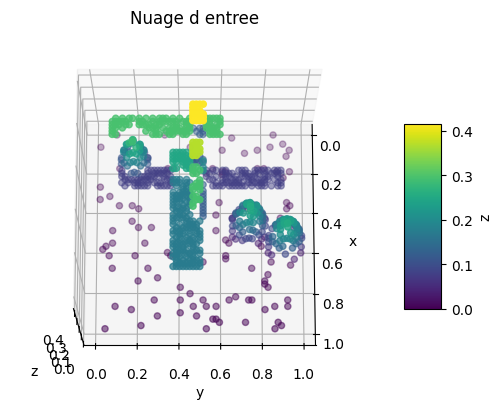

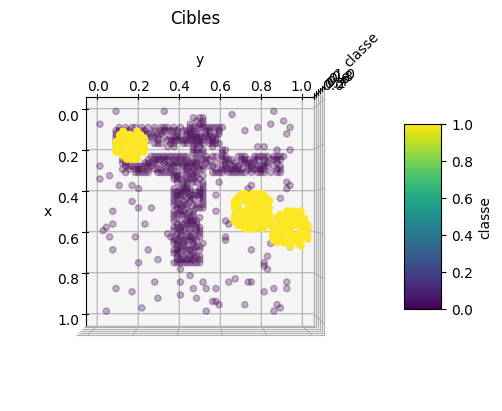

1


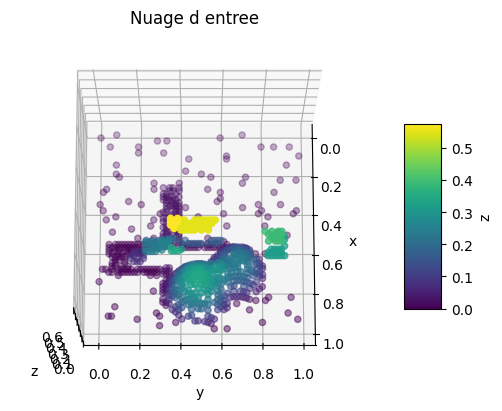

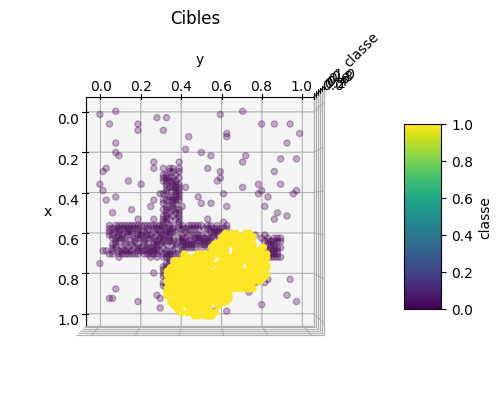

2


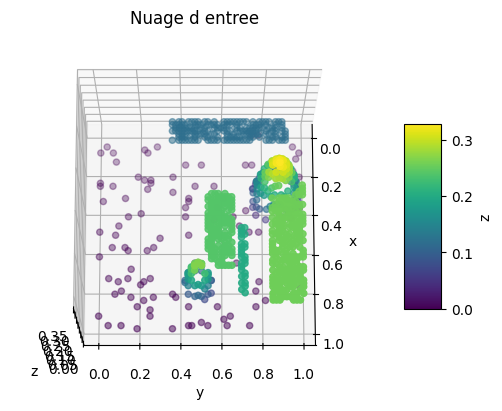

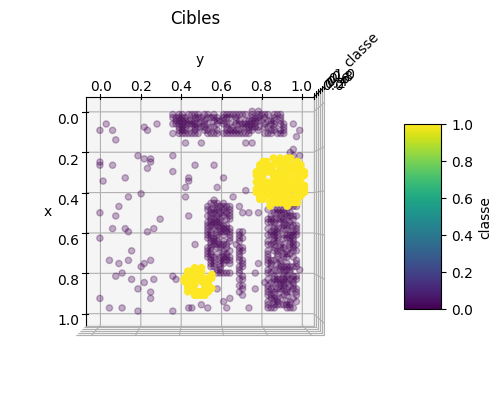

3


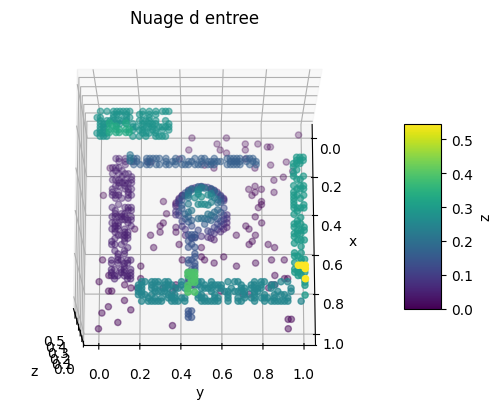

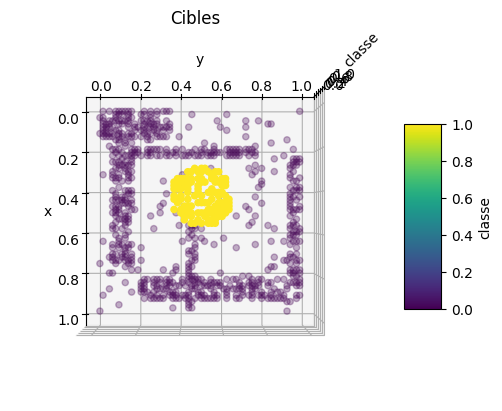

4


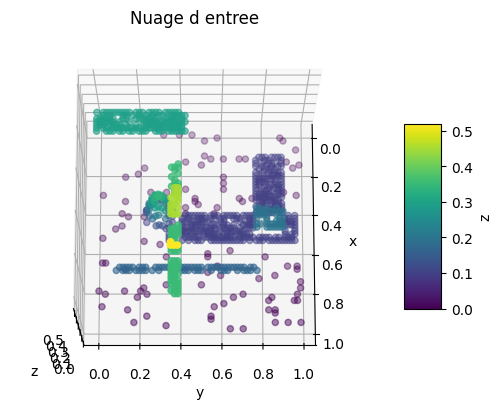

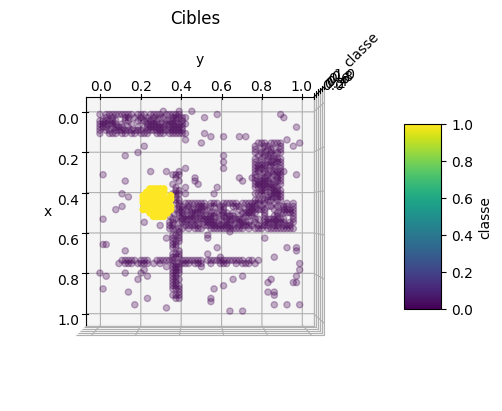

5


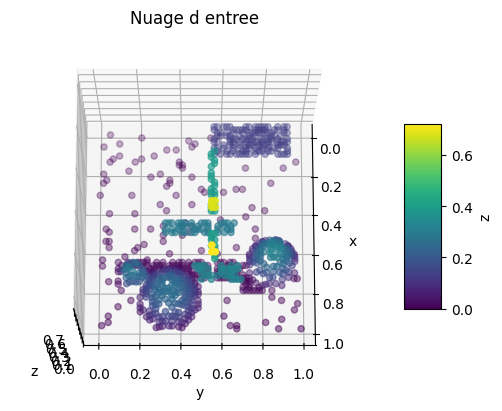

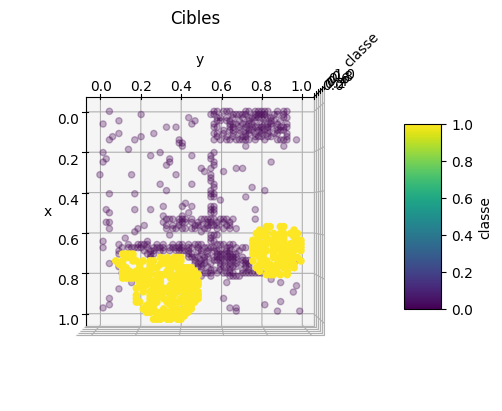

In [3]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [4]:
input_points.shape

torch.Size([6, 3, 800])

Les dimensions de input_points correspondent à :     

6 : Taille du batch (nombre de nuages de points dans un lot).

3 : Coordonnées spatiales des points (x,y,z).

800 : Nombre total de points dans chaque nuage.

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Non, les points d’un nuage ne sont pas rangés dans un ordre particulier. Les nuages de points sont invariants aux permutations, ce qui justifie l’utilisation d’architectures adaptées comme PointNet.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

FCN : Convertir le nuage de points en une représentation régulière (grille 3D ou voxelisation) pour l'adapter aux convolutions classiques.

ViT : Traiter chaque point (x,y,z) comme un token individuel en le passant dans un Transformer après une projection linéaire. Ajouter des embeddings de position pour capturer les relations spatiales.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [11]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

In [6]:
output.shape

torch.Size([6, 800, 2])

In [7]:
idx = torch.randperm(input_points.shape[1])

permuted_input_points = input_points[:, idx, :]

permuted_output, _, _ = pointnet(permuted_input_points)

diff = torch.abs(output - permuted_output)

print(diff.max())

tensor(13.9275, device='cuda:0', grad_fn=<MaxBackward1>)


Les dimensions de output sont :
Batch size (6) : Nombre de nuages de points dans le lot.

Nombre de points (800) : Points dans chaque nuage.

Nombre de classes (m=2) : Probabilité que chaque point appartienne à l'une des deux classes (bâtiments ou igloos).

PointNet est conçu pour être invariant aux permutations des points grâce à des opérations d'agrégation symétriques (comme max-pooling), ce qui est confirmé dans l'article (Qi et al., 2017).
Toutefois, le test montre une petite différence (diff.max() > 0), suggérant une invariance presque parfaite mais non absolue due aux transformations locales.

**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

* Différentes opérations conduisant à une segmentation :\
Input Transform : Applique une transformation affine (via T-Net) pour aligner les points dans un espace canonique.\
Feature Transform : Effectue une transformation affine sur les caractéristiques extraites pour améliorer l'invariance géométrique.\
MLP (Multi-Layer Perceptron) : Applique des couches partagées pour apprendre des caractéristiques locales par point.\
Max Pooling : Agrège les caractéristiques locales en un vecteur global invariant à l'ordre des points.\
Concaténation : Combine les caractéristiques globales et locales pour prédire les scores de segmentation.

* Signification de "shared" :\
Les couches MLP sont "partagées" car les mêmes poids sont utilisés pour traiter chaque point indépendamment, garantissant une invariance à l'ordre des points.

* Pourquoi ces opérations sont invariantes :\
L'utilisation de transformations globales (T-Net) et d'agrégations symétriques (Max Pooling) assure que la sortie ne dépend pas de l'ordre d'entrée des points.

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1, dice=True):
        super(PointNetSegLoss, self).__init__()
        self.gamma = gamma
        self.dice = dice
        self.alpha = torch.tensor(alpha, dtype=torch.float32).cuda() if alpha is not None else None


    def forward(self, proba_pred_list, target_list):
        ce_loss = F.cross_entropy(proba_pred_list, target_list, weight=self.alpha)

        if self.dice:
            dice_loss = self.dice_loss(proba_pred_list, target_list)
            loss = ce_loss + dice_loss
        else:
            loss = ce_loss

        return loss

    def dice_loss(self, proba_pred_list, target_list):
        num = 2 * torch.sum((proba_pred_list.argmax(dim=1) == target_list).float())
        den = torch.sum(proba_pred_list.argmax(dim=1).float()) + torch.sum(target_list.float())
        dice_loss = 1 - (num + 1) / (den + 1)
        return dice_loss

In [23]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
alpha = torch.tensor(alpha, dtype=torch.float32)

gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
input_points, target_list, _ = gen_pointcloud(batch_size)  # Generate data
input_points = input_points.cuda()
target_list = target_list.cuda()
outputs, _, _ = pointnet(input_points)
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

<ipython-input-22-ad399abdd325>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha = torch.tensor(alpha, dtype=torch.float32).cuda() if alpha is not None else None


tensor(-0.7598, device='cuda:0', grad_fn=<AddBackward0>)

In [24]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs + 1):
    print('Epoch :', epoch)
    for batch in range(1, n_batch_per_epoch + 1):
        # Générer des données
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()

        # Calculer la sortie et la perte
        outputs, _, _ = pointnet(input_points)
        loss = loss_fn(outputs.transpose(1, 2), target_list)

        # Mettre à jour les poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Afficher la justesse des prédictions
    with torch.no_grad():
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()
        outputs, _, _ = pointnet(input_points)
        predictions = outputs.transpose(1, 2).max(1)[1]
        accuracy = (predictions == target_list).float().mean().item()
        print('Justesse :', accuracy)

Epoch : 1
Justesse : 0.5143359303474426
Epoch : 2
Justesse : 0.5682030916213989
Epoch : 3
Justesse : 0.542285144329071
Epoch : 4
Justesse : 0.5244335532188416
Epoch : 5
Justesse : 0.5680468678474426
Epoch : 6
Justesse : 0.5409765243530273
Epoch : 7
Justesse : 0.5539648532867432
Epoch : 8
Justesse : 0.5289257764816284
Epoch : 9
Justesse : 0.5118554830551147
Epoch : 10
Justesse : 0.49193358421325684
Epoch : 11
Justesse : 0.49605467915534973
Epoch : 12
Justesse : 0.49755859375
Epoch : 13
Justesse : 0.4883398413658142
Epoch : 14
Justesse : 0.4820507764816284
Epoch : 15
Justesse : 0.5200390219688416
Epoch : 16
Justesse : 0.5019335746765137
Epoch : 17
Justesse : 0.5322070121765137
Epoch : 18
Justesse : 0.4824609160423279
Epoch : 19
Justesse : 0.4923437535762787
Epoch : 20
Justesse : 0.5179296731948853
Epoch : 21
Justesse : 0.49531248211860657
Epoch : 22
Justesse : 0.45949217677116394
Epoch : 23
Justesse : 0.4408203065395355
Epoch : 24
Justesse : 0.46226561069488525
Epoch : 25
Justesse : 0.47

--2025-01-10 15:40:22--  https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.17, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/c4/87/c48766163a0775a1a0ec83d87695ccdf01e77baf65f77019b3125b730fffb025/7c1831335a0fdde208b94b592c27c5745910a868414cebc6fbc51786ceae6905?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pointnet_500_ep.pth%3B+filename%3D%22pointnet_500_ep.pth%22%3B&Expires=1736782822&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNjc4MjgyMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2M0Lzg3L2M0ODc2NjE2M2EwNzc1YTFhMGVjODNkODc2OTVjY2RmMDFlNzdiYWY2NWY3NzAxOWIzMTI1YjczMGZmZmIwMjUvN2MxODMxMzM1YTBmZGRlMjA4Yjk0YjU5MmMyN2M1NzQ1OTEwYTg2ODQxNGNlYmM2ZmJjNTE3ODZjZWFlNjkwNT9

<ipython-input-27-22222c8332b7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pointnet.load_state_dict(torch.load('pointnet_500_ep.pth'))


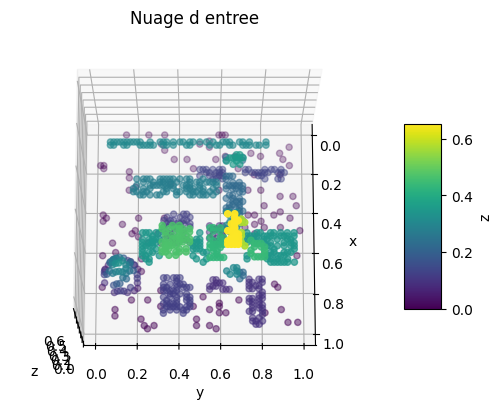

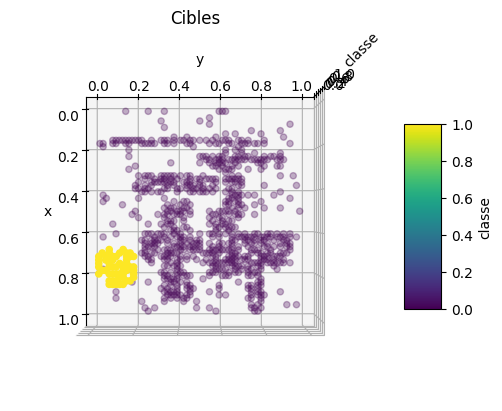

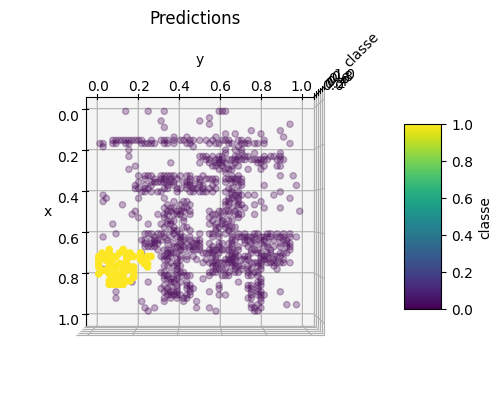

1


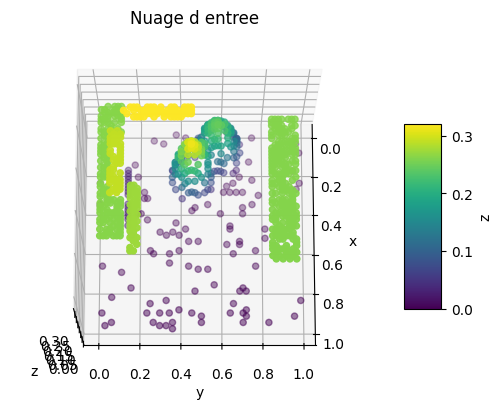

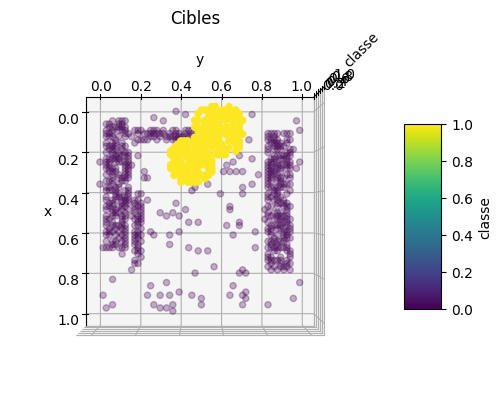

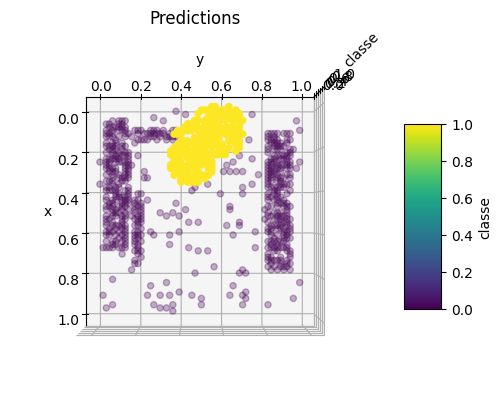

2


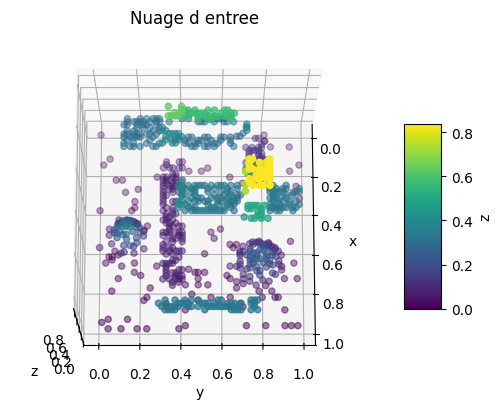

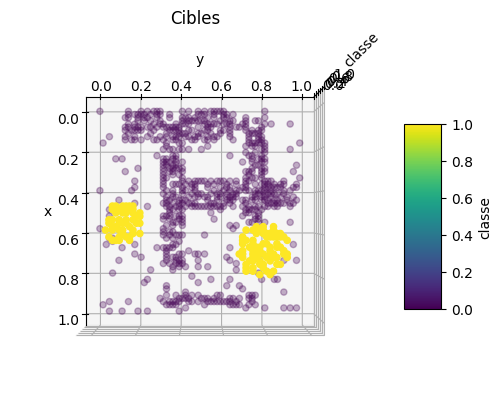

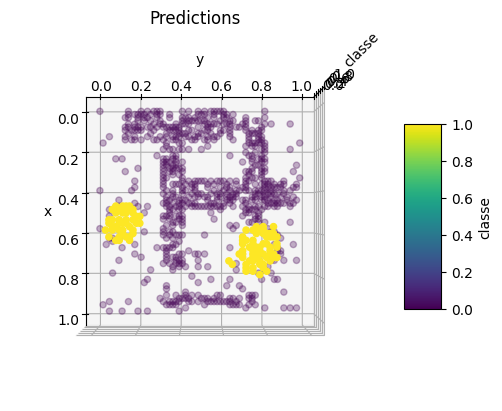

3


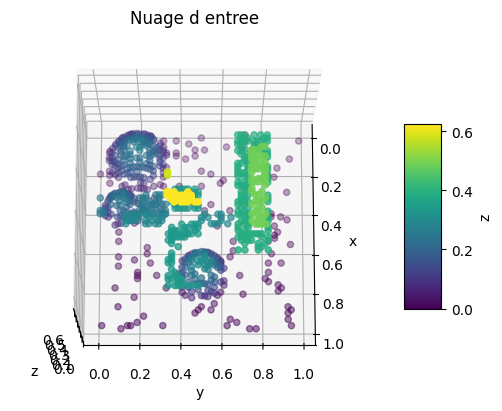

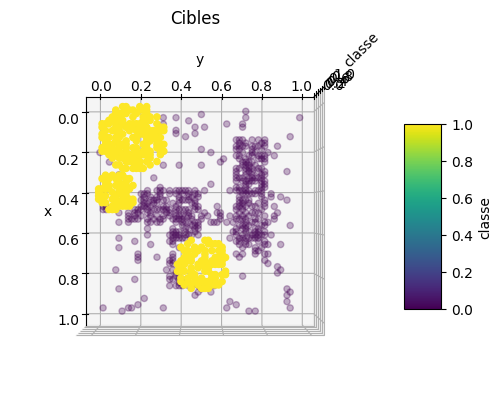

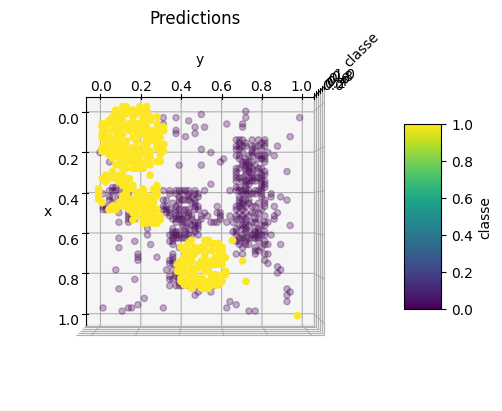

4


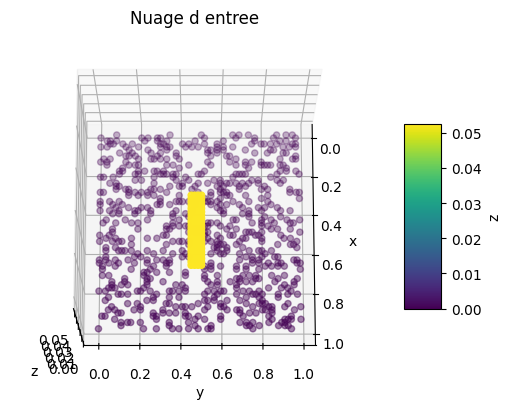

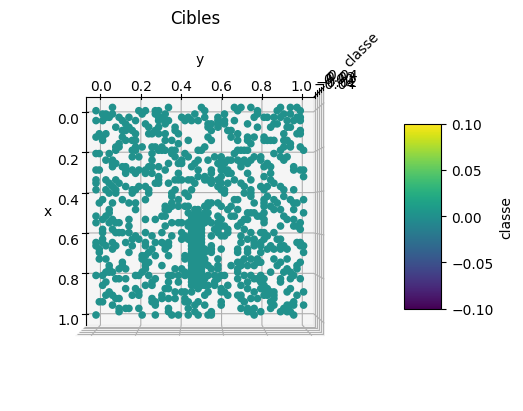

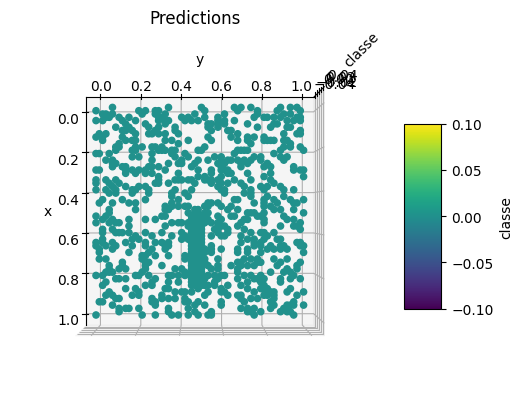

5


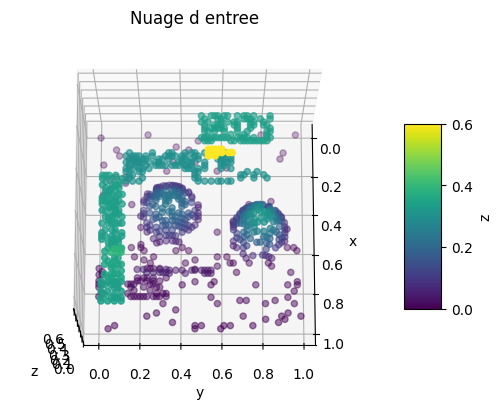

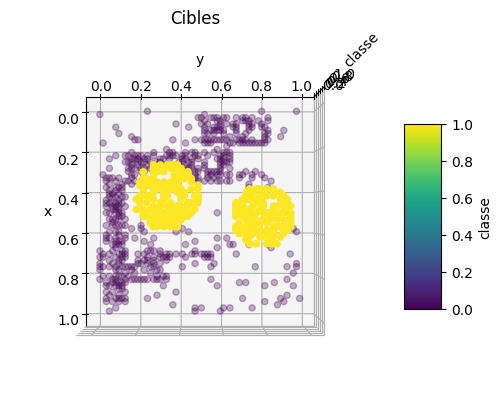

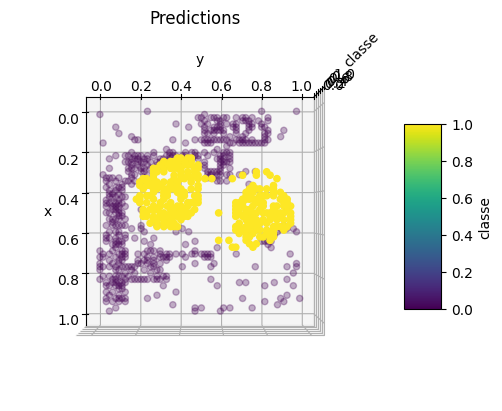

In [27]:
# Charger les poids pré-entraînés
!wget https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth -O pointnet_500_ep.pth # Télécharger le fichier de poids
pointnet.load_state_dict(torch.load('pointnet_500_ep.pth'))

# Générer des données et les transférer sur le GPU
input_points, target_list, target_points = gen_pointcloud(6)
input_points = input_points.cuda()

# Il faut construire les prédictions.
with torch.no_grad():
  proba_pred_list, _, _ = pointnet(input_points)
  pred_list = proba_pred_list.transpose(1, 2).max(1)[1].cpu()

# Accuracy:
accuracy = (pred_list == target_list.cpu()).float().mean().item()
print('Justesse :', accuracy)

# Tracé
for i in range(6):
  print(i)
  # Move input_points to CPU before plotting
  plot_triplets(input_points[i].transpose(0, 1).cpu(), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0, 1), title='Cibles', cbar_label='classe')
  # Modification to fix the IndexError
  plot_triplets(torch.cat([input_points[i].transpose(0, 1).cpu()[:, :2], pred_list[i].unsqueeze(1)], dim=1), title='Predictions', cbar_label='classe')